In [1]:
# There should be classes 
# The classes should be able to run backtesting  - determine rolling xirr and rolling abs return
# Should be able to set modes - trade /invest
# Should have an utility to show predicted trade for a date

In [2]:
class BaseTech(object):
    
    min_lookback = 0
    
    def __init__(self, df):
        self.df = df.copy()
        new_row = {'Date': datetime.today().strftime('%Y-%m-%d'),
            'prevClose': self.df.at[len(self.df)-1, 'Close'] }
        self.df = self.df.append(new_row, ignore_index=True)
        return
    
    def strategy(self):
        pass
    
    def backtest(self, start_date, end_date, plot=False ):
        backtest_df = self.df.copy()
        backtest_df = backtest_df[(backtest_df.Date>start_date) & (backtest_df.Date < end_date)]
        backtest_df[['xirr', 'unrealized_ret']] = backtest_df.apply(lambda row:find_row_returns(row, backtest_df),
                                                                    axis=1, result_type='expand')
        return backtest_df
    
    def get_trade(self, trade_date):
        row =  self.df[self.df.Date == trade_date]
        if len(row):
            return float(row['qty_traded'])
        else:
            return 0        

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('GOLD_ETF.csv')

In [5]:
df['prevClose'] =df.Close.shift(1)

In [6]:
from pyxirr import xirr
def find_xirr(df):
    if len(df) <=2 :
        return (0,0)
    df['trading_price'] = df.qty_traded * -1.0 * df.Close
    df['total_qty'] = df['qty_traded'].cumsum()
    df['inflow'] = df['trading_price']
    df['mktval'] = df['total_qty'] * df['Close']
    tot_cost = df['inflow'].sum() * -1
    tot_val = df.at[len(df)-1, 'mktval']
    df.at[len(df)-1, 'inflow'] = df.at[len(df)-2, 'mktval']

    return (xirr(df.Date, df.inflow), (tot_val/tot_cost)-1 )

def find_row_returns(row, whole_df):
    limited_history = whole_df[whole_df.Date <= row.Date].copy()
    limited_history = limited_history.reset_index()
    try:
        data = find_xirr(limited_history)
    except:
        data = (0, 0)
    return data
    

In [7]:
from datetime import datetime
class SIP(BaseTech):
    
    min_lookback = 2
    
    def apply_strategy(self):
        self.df['qty_traded'] = 1
                

In [8]:
SIPobj = SIP(df)

/var/folders/05/xdl3n7b519g2ls5rdzbb2tkm0000gn/T/ipykernel_1412/1094271224.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(new_row, ignore_index=True)


In [9]:
SIPobj.apply_strategy()

In [13]:
data2 = SIPobj.backtest('2020-03-01', '2023-04-10')

In [14]:
data2.unrealized_ret

2285    0.000000
2286    0.000000
2287    0.019961
2288    0.014059
2289    0.045507
          ...   
3050    0.185089
3051    0.191070
3052    0.182188
3053    0.214848
3054    0.205929
Name: unrealized_ret, Length: 770, dtype: float64

<Axes: xlabel='Date'>

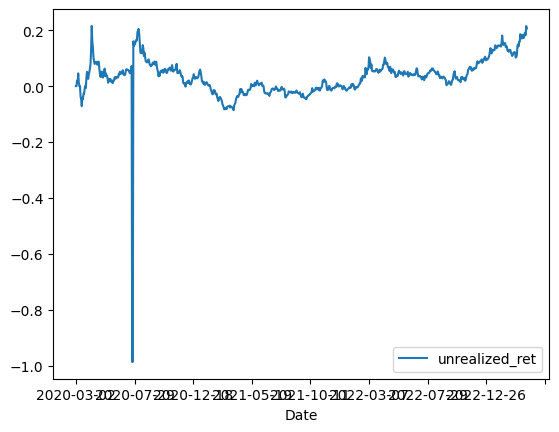

In [15]:
data2 = data2.reset_index()
data2.plot(x='Date', y='unrealized_ret', kind='line')

In [ ]:
SIPobj.get_trade('2023-04-14')

In [16]:
class RollingMeanDev(BaseTech):
    
    min_lookback = 2
    
    def apply_strategy(self):        
        self.df['moving_avg_30'] = self.df.prevClose.rolling(window=30).mean()
        self.df['qty_traded'] = self.df.apply(lambda row: 1 if (row.moving_avg_30 - row.prevClose)/row.prevClose > 0.06 else 0 , axis=1)
        self.df['qty_traded'] =self.df.apply(lambda row: -1 if (row.prevClose -row.moving_avg_30)/row.prevClose > 0.06 else row.qty_traded , axis=1)
        #self.df['qty_traded'] = 1
        
    def backtest(self, start_date, end_date, plot=False ):
        backtest_df = self.df.copy()
        backtest_df = backtest_df[(backtest_df.Date>start_date) & (backtest_df.Date < end_date)]
        backtest_df[['xirr', 'unrealized_ret']] = backtest_df.apply(lambda row:find_row_returns(row, backtest_df),
                                                                    axis=1, result_type='expand')
        return backtest_df
    
    def get_trade(self, trade_date):
        row =  self.df[self.df.Date == trade_date]
        if len(row):
            return float(row['qty_traded'])
        else:
            return 0


In [17]:
RMobj = RollingMeanDev(df)

/var/folders/05/xdl3n7b519g2ls5rdzbb2tkm0000gn/T/ipykernel_1412/1094271224.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(new_row, ignore_index=True)


In [18]:
RMobj.apply_strategy()

In [20]:
data2 = RMobj.backtest('2020-03-01', '2023-04-10')

<Axes: xlabel='Date'>

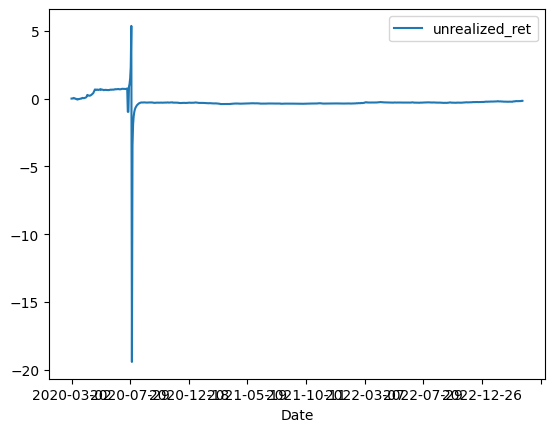

In [21]:
data2 = data2.reset_index()
data2.plot(x='Date', y='unrealized_ret', kind='line')

In [22]:
data2.unrealized_ret

0      0.000000
1      0.000000
2      0.019961
3      0.014059
4      0.045507
         ...   
765   -0.180650
766   -0.176310
767   -0.182258
768   -0.159431
769   -0.165379
Name: unrealized_ret, Length: 770, dtype: float64

In [19]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

def pythag(pt1, pt2):
    a_sq = (pt2[0] - pt1[0]) ** 2
    b_sq = (pt2[1] - pt1[1]) ** 2
    return sqrt(a_sq + b_sq)

def regression_ceof(pts):
    X = np.array([pt[0] for pt in pts]).reshape(-1, 1)
    y = np.array([pt[1] for pt in pts])
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0], model.intercept_

def local_min_max(pts):
    local_min = []
    local_max = []
    prev_pts = [(0, pts[0]), (1, pts[1])]
    for i in range(1, len(pts) - 1):
        append_to = ''
        if pts[i-1] > pts[i] < pts[i+1]:
            append_to = 'min'
        elif pts[i-1] < pts[i] > pts[i+1]:
            append_to = 'max'
        if append_to:
            if local_min or local_max:
                prev_distance = pythag(prev_pts[0], prev_pts[1]) * 0.5
                curr_distance = pythag(prev_pts[1], (i, pts[i]))
                if curr_distance >= prev_distance:
                    prev_pts[0] = prev_pts[1]
                    prev_pts[1] = (i, pts[i])
                    if append_to == 'min':
                        local_min.append((i, pts[i]))
                    else:
                        local_max.append((i, pts[i]))
            else:
                prev_pts[0] = prev_pts[1]
                prev_pts[1] = (i, pts[i])
                if append_to == 'min':
                    local_min.append((i, pts[i]))
                else:
                    local_max.append((i, pts[i]))
    return local_min, local_max

def get_rolling_swing(row):
    series = df[df.Date<row.Date]['Close']
    if len(series)<200:
        return [None, None]
    series = series[-200:]
    
    series.index = np.arange(series.shape[0])

    month_diff = series.shape[0] // 30
    if month_diff == 0:
        month_diff = 1

    smooth = int(2 * month_diff + 3)

    pts = savgol_filter(series, smooth, 3)

    local_min, local_max = local_min_max(pts)
    
    
    if len(local_min):
        local_min_slope, local_min_int = regression_ceof(local_min)
        support = (local_min_slope * np.array(series.index)) + local_min_int
    else:
        support = [None,]
        
    if len(local_max):
        local_max_slope, local_max_int = regression_ceof(local_max)
        resistance = (local_max_slope * np.array(series.index)) + local_max_int
    else :
        resistance = [None,]

    return [support[-1],resistance[-1]]


class SR(BaseTech):
    
    min_lookback = 2
    
    def apply_strategy(self):
        self.df[['support', 'resistance']] = self.df.apply(lambda row:get_rolling_swing(row), axis=1, result_type='expand')
        self.df['supported'] = self.df.apply(lambda row: 1 if row.prevClose<row.support else 0 , axis =1)
        self.df['resisted'] = self.df.apply(lambda row: 1 if row.prevClose>row.resistance else 0, axis =1)
        self.df['rolling_support'] = self.df.supported.rolling(10, min_periods=1).sum()
        self.df['rolling_resistance'] = self.df.resisted.rolling(10, min_periods=1).sum()
        self.df['qty_traded'] = self.df.apply(lambda row: 1 if row.rolling_support == 1.0 else 0 , axis=1)
        self.df['qty_traded'] =self.df.apply(lambda row: -1 if row.rolling_resistance == 1.0 else row.qty_traded , axis=1)
        return


In [20]:
srobj = SR(df)

/var/folders/05/xdl3n7b519g2ls5rdzbb2tkm0000gn/T/ipykernel_1390/1094271224.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(new_row, ignore_index=True)


In [21]:
srobj.apply_strategy()

In [22]:
data2 = srobj.backtest('2015-01-01', '2023-04-10')

<Axes: xlabel='Date'>

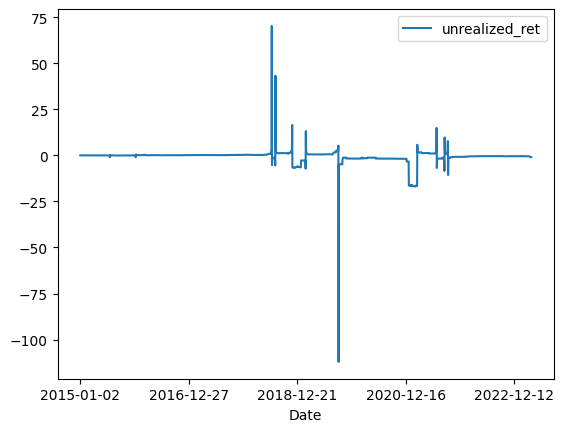

In [23]:
data2 = data2.reset_index()
data2.plot(x='Date', y='unrealized_ret', kind='line')

In [24]:
data2.unrealized_ret

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2075   -1.0
2076   -1.0
2077   -1.0
2078   -1.0
2079   -1.0
Name: unrealized_ret, Length: 2080, dtype: float64

In [25]:
import numpy as np
def hammer_trade(row):
    if row.prevOpen > row.prevClose : 
        if (row.prevOpen - row.prevClose)/ (row.prevHigh - row.prevLow) < 0.25:
            return 1
    if row.prevClose > row.prevOpen : 
        if (row.prevClose - row.prevOpen)/ (row.prevHigh - row.prevLow) < 0.25:
            return -1
    else : 
        return 0
    

class Hammer(BaseTech):
    
    min_lookback = 2
    
    def apply_strategy(self):
        self.df['prevClose'] = self.df.Close.shift(1)
        self.df['prevOpen'] = self.df.Open.shift(1)
        self.df['prevHigh'] = self.df.High.shift(1)
        self.df['prevLow'] = self.df.Low.shift(1)
        self.df['qty_traded'] = self.df.apply(lambda row: hammer_trade(row) , axis=1)
        hamobj.df.qty_traded = hamobj.df.qty_traded.replace(np.nan, 0)
        return
        

In [26]:
hamobj = Hammer(df)

/var/folders/05/xdl3n7b519g2ls5rdzbb2tkm0000gn/T/ipykernel_1390/1094271224.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(new_row, ignore_index=True)


In [28]:
hamobj.apply_strategy()

In [29]:
data2 = hamobj.backtest('2015-01-01', '2017-01-31')

In [30]:
data2.unrealized_ret

1258    0.000000
1259    0.000000
1260   -0.008893
1261    0.002633
1262    0.020568
          ...   
1776   -0.009850
1777   -0.001903
1778   -0.002637
1779   -0.003501
1780   -0.009490
Name: unrealized_ret, Length: 523, dtype: float64

<Axes: xlabel='Date'>

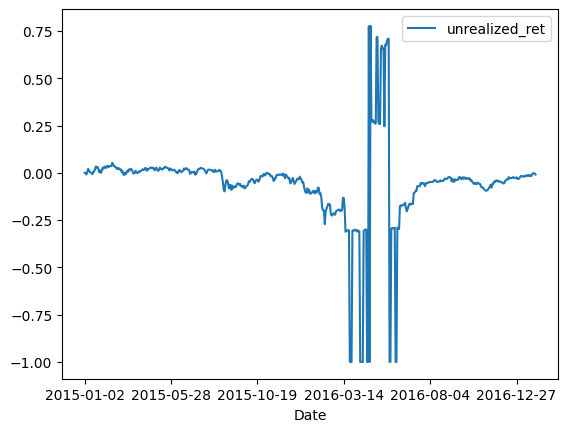

In [31]:
data2 = data2.reset_index()
data2.plot(x='Date', y='unrealized_ret', kind='line')

In [23]:
def get_momentum(row):
    if row.cur_idx < 120:
        return 0
    lag_30_price = float(df.iloc[[row.cur_idx - 30]]['prevClose'])
    lag_90_price = float(df.iloc[[row.cur_idx - 60]]['prevClose'])
    lag_120_price = float(df.iloc[[row.cur_idx - 120]]['prevClose'])
    
    cur_price = row.prevClose
    
    if((cur_price> lag_30_price) & (cur_price > lag_90_price) & (cur_price > lag_120_price)):
        return 1
    
    if ((cur_price< lag_30_price) & (cur_price < lag_90_price) & (cur_price < lag_120_price)):
        return -1
    
    
    return 0


class Momentum(BaseTech):
    
    min_lookback = 2
    
    def apply_strategy(self):
        self.df['cur_idx'] = self.df.index
        self.df['momentum_ind'] = self.df.apply(lambda row: get_momentum(row), axis=1)
        self.df['qty_traded'] = self.df['momentum_ind']
        return
        

In [24]:
mobj = Momentum(df)

/var/folders/05/xdl3n7b519g2ls5rdzbb2tkm0000gn/T/ipykernel_1412/1094271224.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(new_row, ignore_index=True)


In [25]:
mobj.apply_strategy()

In [26]:
data2 = mobj.backtest('2020-03-01', '2023-04-10')

In [27]:
data2.unrealized_ret

2285    0.000000
2286    0.000000
2287    0.019961
2288    0.014059
2289    0.045507
          ...   
3050   -0.050270
3051   -0.044692
3052   -0.050978
3053   -0.024192
3054   -0.030729
Name: unrealized_ret, Length: 770, dtype: float64

<Axes: xlabel='Date'>

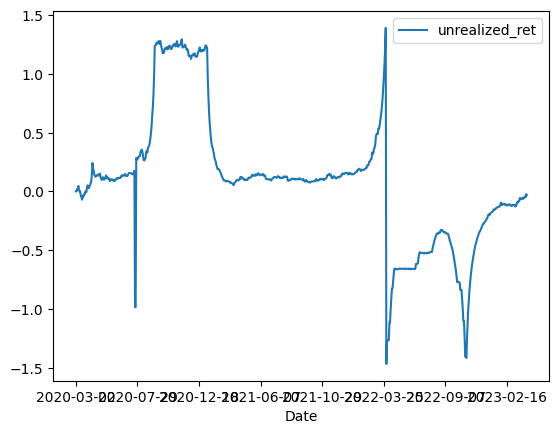

In [28]:
data2 = data2.reset_index()
data2 = data2[data2.unrealized_ret.abs() < 1.5]
data2.plot(x='Date', y='unrealized_ret', kind='line')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Momentum
sns.lineplot(x='Date', y='xirr', data=data2)
#sns.lineplot(x='Date', y='moving_avg_30', data=df)
plt.xticks(rotation=20)